In [25]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from scipy.ndimage import imread
import warnings

%matplotlib inline

In [3]:
# Loading the data (mask/non_mask)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
test_set_x_orig.shape

(50, 65, 65, 3)

y = [0], it's a 'non-mask' picture.


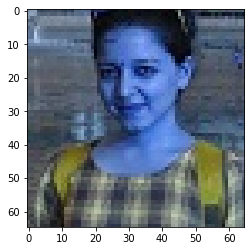

In [4]:
# Example of a picture
index = 103
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")


In [5]:

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 150
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 65
Each image is of size: (65, 65, 3)
train_set_x shape: (150, 65, 65, 3)
train_set_y shape: (1, 150)
test_set_x shape: (50, 65, 65, 3)
test_set_y shape: (1, 50)


In [6]:
# Reshape the training and test examples
#this transposing is same as multiplting the pixel values

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))
#train_set_x_flatten.shape

train_set_x_flatten shape: (12675, 150)
train_set_y shape: (1, 150)
test_set_x_flatten shape: (12675, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [23 46 42 10 31]


In [7]:
#Normalizing the rows of the image matrix by the mean which is 255
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

In [8]:
# sigmoid of the hypothesis(prediction)

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [9]:
#initializing w which is weights of every inputs and b which is the bias of every input to 0

def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim,1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [10]:
#finding the cost of our model and finding the least value of the cost 

def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    
    cost = -(1/m)*(np.sum((Y*np.log(A))+((1-Y)*np.log(1-A))))
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return  grads,cost

In [11]:
#for testing purpose
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])

grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [12]:
# Functions to optimize the parameters 

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation                                      
        grads, cost = propagate(w, b, X, Y)
    
        
        # Retrieving derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w -= learning_rate*dw
        b -= learning_rate*db
        
        # for Recording the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [13]:
#for testing purpose
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


In [14]:
# we wil now use the learned parameters w and b to to predict the labels for dataset X

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X)+b)

    
    for i in range(A.shape[1]):
        
        # Converting probabilities A[0,i] to actual predictions p[0,i]


        if A[0,i]>0.5:
            Y_prediction[0,i]=1
        else:
            0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [15]:
#for testing purpose
w = np.array([[0.1124579],
              [0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],
              [1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


In [16]:
# Now we will test our model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [17]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.745928
Cost after iteration 200: 0.285971
Cost after iteration 300: 0.179344
Cost after iteration 400: 0.148905
Cost after iteration 500: 0.127163
Cost after iteration 600: 0.110764
Cost after iteration 700: 0.097967
Cost after iteration 800: 0.087723
Cost after iteration 900: 0.079350
Cost after iteration 1000: 0.072388
Cost after iteration 1100: 0.066515
Cost after iteration 1200: 0.061497
Cost after iteration 1300: 0.057164
Cost after iteration 1400: 0.053387
Cost after iteration 1500: 0.050066
Cost after iteration 1600: 0.047125
Cost after iteration 1700: 0.044503
Cost after iteration 1800: 0.042152
Cost after iteration 1900: 0.040032
train accuracy: 100.0 %
test accuracy: 62.0 %


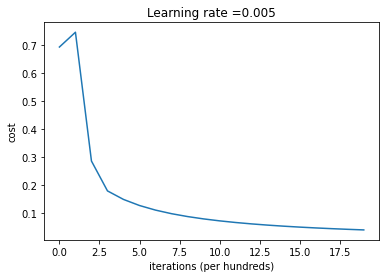

In [18]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

y = 0.0, your algorithm predicts a "non-mask" picture.


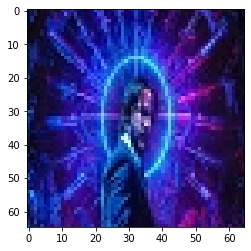

In [28]:
# (PUT YOUR IMAGE NAME) 
my_image = "JohnWick.jpg"   

# now we will process the custom images
fname = "images/" + my_image
image = np.array(ndimage.imread(fname,flatten=False))
warnings.filterwarnings("ignore")
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
warnings.filterwarnings("ignore")